In [46]:
# Imports for project

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

Our goal is to see if we can find any characteristics of a movie that can help predict its financial and critical success. For our case, we will define financial success as the revenue earned and critical success as the weighted ratings from IMDB. First we need to gather the data sets that we will be using and creating the data frame. We'll begin by creating a dataframe with the weighted ratings from movies since IMDB only provides the formula used and not the dataset itself.

In [47]:
# Renamed data from title.ratings.tsv.gz->data.tsv
ratings = pd.read_csv('../cogs108_data/ratings.tsv',delimiter='\t')
# Renamed data from title.basics.tsv.gz->data.tsv
basics = pd.read_csv('../cogs108_data/basics.tsv', delimiter='\t')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [48]:
# Remove all things that arent movies
basics = basics[basics['titleType'] == "movie"]
# Remove all adult titles
basics = basics[basics['isAdult'] == 0]
# Remove unnecessary columns
basics = basics.drop(['titleType','originalTitle','isAdult','startYear','endYear','runtimeMinutes','genres'],axis=1)

In [49]:
# Do a inner join on movies that have both ratings and basic info
ratings_df = pd.merge(basics, ratings, on='tconst', how='inner')

In [50]:
# Add a new column with weighted ratings based on minimum votes
minVote = 30000

# Scroll down to the bottom of the following link to check how the weighted rating was calculated
# https://help.imdb.com/article/imdb/track-movies-tv/faq-for-imdb-ratings/G67Y87TFYYP6TWAV?ref_=helpsect_pro_2_4#
ratings_df = ratings_df.assign(weighted_ratings=((ratings_df['numVotes']/(ratings_df['numVotes']+minVote))*ratings_df['averageRating'])+(minVote/(ratings_df['numVotes']+minVote))*ratings_df['averageRating'].mean())
# Standardize movie names
ratings_df['primaryTitle']=ratings_df['primaryTitle'].str.strip()
ratings_df['primaryTitle']=ratings_df['primaryTitle'].str.lower()


ratings_df.rename(index=str, columns={"tconst": "imdb_id"}, inplace=True)


# Remove the comment below to see the weighted ratings DF
# df.sort_values(by=['weighted_ratings'], ascending=False)

Now let's get the other quantitative measures for movies, such as budget and revenue. We can then combine both dataframes on the IMDB ID to start our analysis.

In [51]:
budget_df = pd.read_csv("../cogs108_data/movies_metadata.csv")

# Cleaning up the dataset for some useful analysis on budget since it contains A LOT of information
budget_df.drop(["adult", "belongs_to_collection", "genres", "homepage", "id", "original_language", "runtime", 
                "spoken_languages", "status", "tagline", "poster_path", "production_countries", 
                "original_title", "overview", "video"], inplace = True, axis=1)


# Strip whitespace and tolower for consistency
budget_df["title"]=budget_df["title"].str.strip()
budget_df["title"]=budget_df["title"].str.lower()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [52]:
# This function will be used to change some of the columns since some of them are numbers but as strings
def convertToInt(string):
    return int(string)

In [53]:
# Now we need to start cleaning our data because there are some incorrect inputs and 
# a lot of rows with missing budget and revenue information
print("Shape before cleaning - " + str(budget_df.shape))
budget_df = budget_df[(budget_df["budget"] != "0")]
budget_df = budget_df[(budget_df["revenue"] != 0)]

# For some reason the following rows were completely messed up so we have to remove them
budget_df = budget_df[(budget_df["budget"] != "/ff9qCepilowshEtG2GYWwzt2bs4.jpg")]
budget_df = budget_df[(budget_df["budget"] != "/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg")]
budget_df = budget_df[(budget_df["budget"] != "/zaSf5OG7V8X8gqFvly88zDdRm46.jpg")]

print("Shape after cleaning - " + str(budget_df.shape))

Shape before cleaning - (45466, 9)
Shape after cleaning - (5381, 9)


In [54]:
# Now let's go ahead and apply the function we made earlier and now combine our dataframes
budget_df["budget"] = budget_df["budget"].apply(convertToInt)
combined_df = pd.merge(ratings_df, budget_df, on="imdb_id")

combined_df.drop(["primaryTitle", "popularity", "production_companies"], axis=1, inplace=True)


# Uncomment the following line to see the new DF
# combined_df


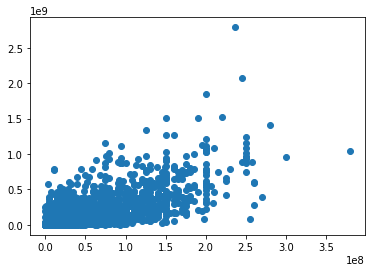

In [55]:
plt.scatter(combined_df.budget, combined_df.revenue)

It's somewhat hard to see any sort of relationship with this graph because of the numbers. To try to see anything interesting we'll go ahead and apply a log transformation to both the budget and revenue.

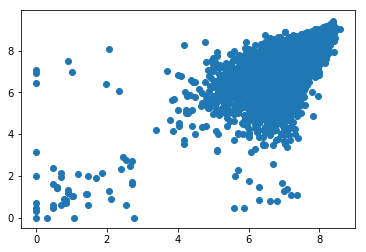

In [56]:
combined_df["budget"] = np.log10(combined_df["budget"])
combined_df["revenue"] = np.log10(combined_df["revenue"])

#Scatter after log transform
plt.scatter(combined_df.budget, combined_df.revenue)

Now we can definitely see that there is some sort of correlation between the budget that a movie receives and the revenue that it earns. We can see that there is this general positive trend where a movie that has a higher budget earns more revenue. This makes sense since a higher budget usually means higher faith in the outcome by the company funding the movie.

We do notice that this is not a perfect correlation, however. Just because a movie receives a high budget does not mean that is guaranteed to do well. The opposite of this is also true. 

In [57]:
# We have to create the following function if we want to do any more useful analysis with the budget and revenue
def revertLog(input):
    return np.float_power(10, input)


combined_df["budget"] = combined_df["budget"].apply(revertLog)
combined_df["revenue"] = combined_df["revenue"].apply(revertLog)

Now that we've seen that there is a correlation between a movie's budget and its revenue, we want to ask if there are any other factors that indicate a movie will do well financially. Another characteristic that we may want to consider is the time of the year that a movie does well. It may be possible that movies that are released in a certain part of the year are more likely to generate more revenue than others.

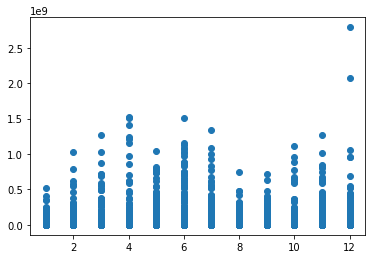

In [58]:
# Strip whitespace and tolower for consistency
combined_df["title"]=combined_df["title"].str.strip()
combined_df["title"]=combined_df["title"].str.lower()


# We have to create ths new column age so we can specify which movies we want to use. Since this dataset
# includes a large number of movies and since the trend in watching movies has changed, we only want 
# to consider a subset for certain analysis.
combined_df["age"] = 0
    
for index, row in combined_df.iterrows():
    year = int(row["release_date"][0:4])
    combined_df.set_value(index,'age', (2017 - year))

# Here we will only be considering movies released in the past 10 years
smaller_combined_df = combined_df[combined_df["age"] < 10]

# We section of the timeline by month
for index, row in smaller_combined_df.iterrows():
    month = int(row["release_date"][5:7])
    smaller_combined_df.set_value(index, "release_date", month)
    
    
plt.scatter(smaller_combined_df.release_date, smaller_combined_df.revenue)

We can see that there's some sort of relationship between month of release and revenue....maybe? It seems like there is some sort of fluctuations, but it's hard to tell exactly what that is. To help us see this trend, we can average out the revenue per month over these movies and display those.

<Container object of 12 artists>

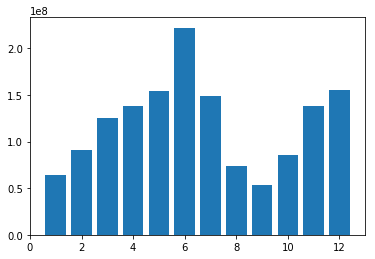

In [60]:
temp_frame = None
months = list()
averages = list()

# Loop that gets the averages for each month
for i in range (1,13):
    temp_frame = smaller_combined_df[smaller_combined_df["release_date"] == i]
    averages.append(temp_frame["revenue"].mean())
    months.append(i)


plt.bar(months, averages)

Now that we took the averages, we can definitely see a trend. It looks like movies that are released in the 
April - July area are likely to earn more revenue than other months. This does seem consistent with the fact that
many more people (like students) have more time during these summer months. As a result, these people are likely 
to see more movies during this period. To confirm this, however, we would probably need to do a bigger analysis 
with more data.

Up until this point we have considered only revenue as a measure of success for a movie. Although this is 
important to the movie industry, there is also another important factor to consider: ratings. Movies that are
rated much more highly are usually praised by many people. As a result, we can use ratings to measure the 
critical success of a movie. We can begin by using the same variables that we did for revenue: budget 
and month of release.

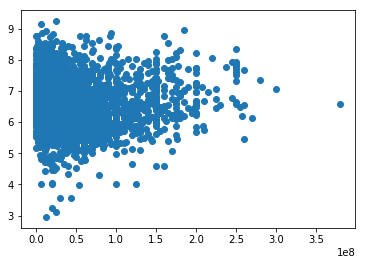

In [61]:
plt.scatter(combined_df.budget, combined_df.weighted_ratings)

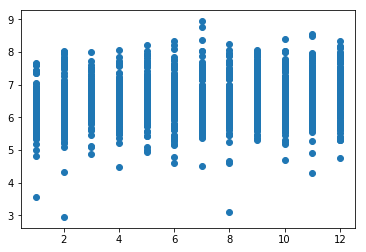

In [62]:
plt.scatter(smaller_combined_df.release_date, smaller_combined_df.weighted_ratings)

<Container object of 12 artists>

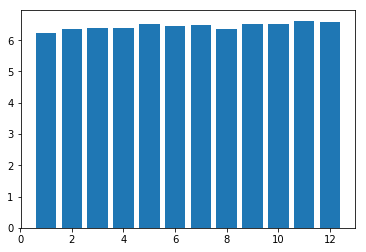

In [66]:
temp_frame = None
months = list()
averages = list()
for i in range (1,13):
    temp_frame = smaller_combined_df[smaller_combined_df["release_date"] == i]
    averages.append(temp_frame["weighted_ratings"].mean())
    months.append(i)


plt.bar(months, averages)